#DCGAN in Tensorflow

In this notebook we will create a Deep Convolutional Generative Adversarial Network (DCGAN) in Tensorflow. Our aim will be to generate images based off of the CIFAR10 Dataset.

In [0]:
%load_ext autoreload
%matplotlib inline

In [2]:
#Import required libraries
%autoreload 2
!pip install --upgrade pip
!pip install torch
!pip install torchvision
!pip install tensorboardx
!pip install pillow

import os
import errno
import scipy
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow import nn, layers
from tensorflow.contrib import layers as clayers 

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision.utils as vutils
from torchvision import transforms, utils, datasets

from tensorboardX import SummaryWriter
from IPython import display



class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (18.1)


## Load Data

In [0]:
DATA_FOLDER = './tf_data/DCGAN/CIFAR'
def cifar_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

In [4]:
dataset = cifar_data()
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

Files already downloaded and verified


In [0]:
IMAGES_SHAPE = (64, 64, 3)
NOISE_SIZE = 100

In [0]:
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
      
def default_conv2d(inputs, filters):
    return layers.conv2d(
        inputs,
        filters=filters,
        kernel_size=4,
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        use_bias=False,
    )

def default_conv2d_transpose(inputs, filters):
    return layers.conv2d_transpose(
        inputs,
        filters=filters,
        kernel_size=4,
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        use_bias=False,
    )

## Define Networks

### The Generator

The generator takes a vector of random numbers and transforms it into a 32x32 image. Each layer in the network involves a strided transpose convolution, batch normalization, and rectified nonlinearity. Tensorflow's slim library allows us to easily define each of these layers.

In [0]:
def generator(z):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        
        with tf.variable_scope("linear"):
            linear = clayers.fully_connected(z, 1024 * 4 * 4)
            
        with tf.variable_scope("conv1_transp"):
            # Reshape as 4x4 images
            conv1 = tf.reshape(linear, (-1, 4, 4, 1024))
            conv1 = default_conv2d_transpose(conv1, 512)
            conv1 = layers.batch_normalization(conv1)
            conv1 = nn.relu(conv1)
        
        with tf.variable_scope("conv2_transp"):
            conv2 = default_conv2d_transpose(conv1, 256)
            conv2 = layers.batch_normalization(conv2)
            conv2 = nn.relu(conv2)
            
        with tf.variable_scope("conv3_transp"):
            conv3 = default_conv2d_transpose(conv2, 128)
            conv3 = layers.batch_normalization(conv3)
            conv3 = nn.relu(conv3)
            
        with tf.variable_scope("conv4_transp"):
            conv4 = default_conv2d_transpose(conv3, 3)
        
        with tf.variable_scope("out"):
            out = tf.tanh(conv4)
    return out

### The Discriminator

The discriminator network takes as input a 64x64x3 image and transforms it into a single valued probability of being generated from real-world data. Again we use tf.slim to define the convolutional layers, batch normalization, and weight initialization.

In [0]:
def discriminator(x):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        with tf.variable_scope("conv1"):
            conv1 = default_conv2d(x, 128)
            conv1 = nn.leaky_relu(conv1,alpha=0.2)
        
        with tf.variable_scope("conv2"):
            conv2 = default_conv2d(conv1, 256)
            conv2 = layers.batch_normalization(conv2)
            conv2 = nn.leaky_relu(conv2,alpha=0.2)
            
        with tf.variable_scope("conv3"):
            conv3 = default_conv2d(conv2, 512)
            conv3 = layers.batch_normalization(conv3)
            conv3 = nn.leaky_relu(conv3,alpha=0.2)
            
        with tf.variable_scope("conv4"):
            conv4 = default_conv2d(conv3, 1024)
            conv4 = layers.batch_normalization(conv3)
            conv4 = nn.leaky_relu(conv3,alpha=0.2)
        
        with tf.variable_scope("linear"):
            linear = clayers.flatten(conv4)
            linear = clayers.fully_connected(linear, 1)
        
        with tf.variable_scope("out"):
            out = nn.sigmoid(linear)
    return out

###Putting the two together

In [0]:
tf.reset_default_graph()

initializer = tf.truncated_normal_initializer(stddev=0.02)

z_in = tf.placeholder(shape=[None,NOISE_SIZE],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,64,64,3],dtype=tf.float32) #Real images

Gz = generator(z_in) 
Dx = discriminator(real_in) 
Dg = discriminator(Gz) 


d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

G_vars = [var for var in tvars if 'generator' in var.name]
D_vars = [var for var in tvars if 'discriminator' in var.name]

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(d_loss, var_list=D_vars)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002).minimize(g_loss, var_list=G_vars)

## Train the Model

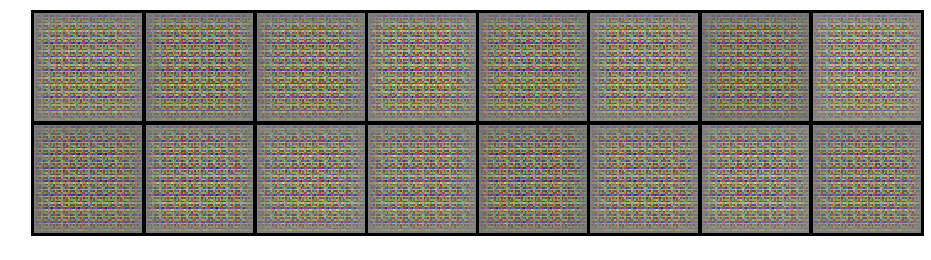

Epoch: [0/200], Batch Num: [0/500]
Discriminator Loss: 1.3798, Generator Loss: 0.6872
D(x): 0.5033, D(G(z)): 0.5000


KeyboardInterrupt: ignored

In [10]:
BATCH_SIZE = 100 #Size of image batch to apply at each iteration.
num_batches = len(dataloader)
iterations = 200 #Total number of iterations to use.

# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run()
# Init Logger
logger = Logger(model_name='DCGAN2', data_name='CIFAR10')
for i in range(iterations):
  for n_batch, (batch,_) in enumerate(dataloader):
            
        # 1. Train Discriminator
        X_batch = batch.permute(0, 2, 3, 1).numpy()
        feed_dict = {real_in: X_batch, z_in: np.random.normal(size=(BATCH_SIZE, NOISE_SIZE))}
        _, d_error, d_pred_real, d_pred_fake = session.run(
            [trainerD, d_loss, Dx, Dg], feed_dict=feed_dict
        )

        # 2. Train Generator
        feed_dict = {z_in: np.random.normal(size=(BATCH_SIZE, NOISE_SIZE))}
        
        #Run generator twice
        _, g_error = session.run([trainerG, g_loss], feed_dict=feed_dict)
        _, g_error = session.run([trainerG, g_loss], feed_dict=feed_dict)
        
        if n_batch % 100 == 0:
            display.clear_output(True)
            # Generate images from test noise
            z2 = np.random.uniform(-1.0,1.0,size=[16,NOISE_SIZE]).astype(np.float32) #Generate another z batch
            test_images = session.run(
                Gz, feed_dict={z_in: z2}
            )
            # Log Images
            logger.log_images(test_images, 16, i, n_batch, num_batches, format='NHWC');
            # Log Status
            logger.display_status(
                i, iterations, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            #Log Variables
            logger.log(d_error, g_error, i, n_batch, num_batches)